# $\textit{Predicción lineal}$
$\textit{By Agustín Luís Gullino - Gonzalo Ezequiel Linares}$

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp
import scipy.io as io
import helper as hp
import importlib
from numpy.fft import fft, rfft
from numpy.fft import fftshift, fftfreq, rfftfreq
from IPython.display import Audio
%load_ext autoreload
%autoreload 2
%matplotlib widget
fs = 16000  # Frecuencia de muestreo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
fss, signal, path = hp.getRecordedSignals()

/home/gullino18/Documents/Github/PASA_TP3/helper.py:18: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs1, aSignal = io.wavfile.read(path[0])
/home/gullino18/Documents/Github/PASA_TP3/helper.py:19: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs2, shSignal = io.wavfile.read(path[1])


In [6]:
from arch.unitroot import ADF
from arch.unitroot import PhillipsPerron

''' 
Para el test, se tiene en cuenta que las hipotesis son:

H0: La serie contiene raiz unitaria.
H1: La serie es estacionaria.

Si el p-valor esta por encima del critico, la hipotesis nula no puede ser rechazada, indicando que 
la serie no es estacionaria.
'''

norm1 = signal["a"]
norm2 = signal["sh"]
max_lags_test=len(signal["a"])//10

adf = ADF(norm1, max_lags=max_lags_test)
print(adf.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal de aaa es estacionaria.")
print('\n//////////////////////////////////////\n')

adf = ADF(norm2, max_lags=max_lags_test)
print(adf.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal de shh estacionaria.")

pp = PhillipsPerron(norm1)
print(pp.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal de aaa estacionaria.")
print('\n//////////////////////////////////////\n')

pp = PhillipsPerron(norm2)
print(pp.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal de shh estacionaria.")

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.030
P-value                         0.001
Lags                              538
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Dado que P-value = 0, podemos concluir que la señal de aaa es estacionaria.

//////////////////////////////////////

   Augmented Dickey-Fuller Results   
Test Statistic                -13.106
P-value                         0.000
Lags                              164
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Dado que P-value = 0, podemos concluir que la señal de shh estacionaria.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -12.

In [143]:
signal["a"] -= np.mean(signal["a"])
signal["sh"] -= np.mean(signal["sh"])

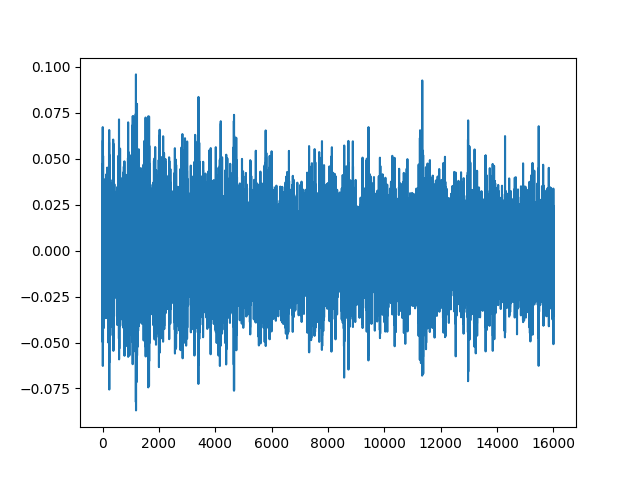

In [179]:
plt.figure()
plt.plot(signal["sh"])

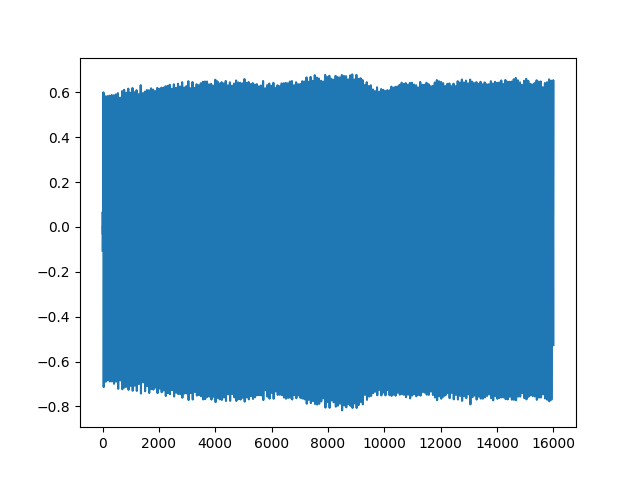

In [178]:
plt.figure()
plt.plot(signal["a"])

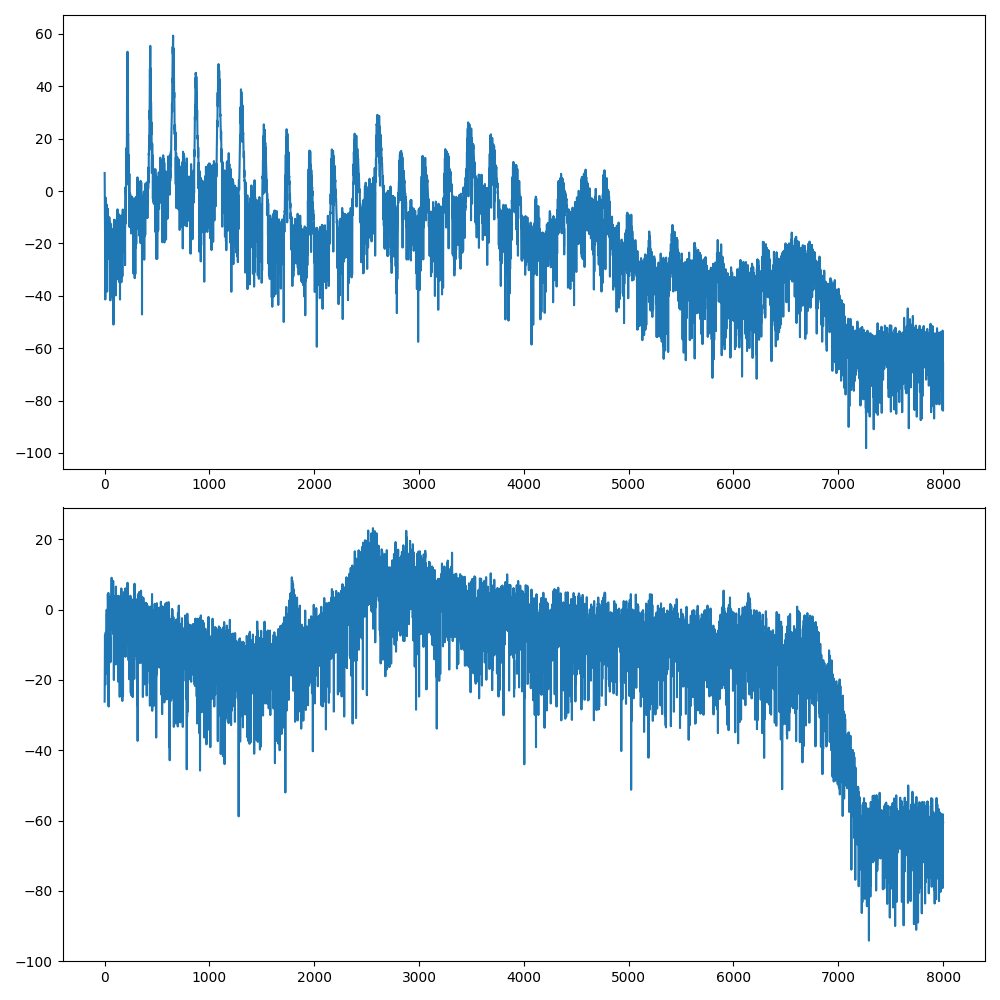

In [110]:
plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(211)
N = len(signal["a"])
window = sp.get_window('hanning', N)
freq = rfftfreq(N*8, 1/fs)
Hejw = rfft(signal["a"]*window, N*8)
A = 20*np.log10((np.abs(Hejw)+1e-18))
plt.plot(freq, A)

plt.subplot(212)
N = len(signal["sh"])
window = sp.get_window('hanning', N)
freq = rfftfreq(N*8, 1/fs)
Hejw = rfft(signal["sh"]*window, N*8)
A = 20*np.log10((np.abs(Hejw)+1e-18))
plt.plot(freq, A)

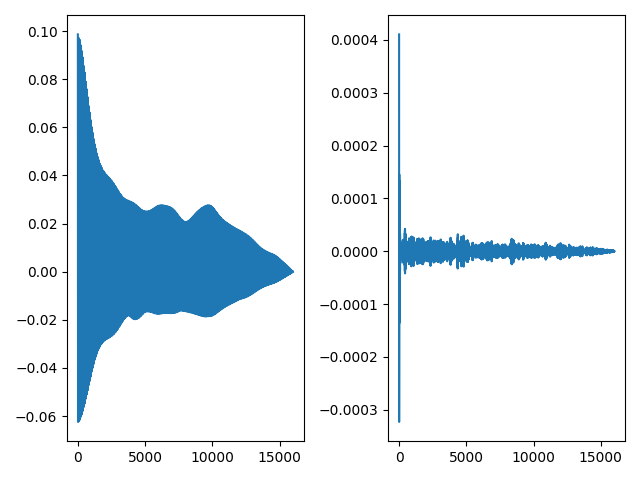

In [111]:
lags = sp.correlation_lags(len(signal["a"]), len(signal["a"]))
N = len(signal["a"])
rxa = sp.correlate(signal["a"], signal["a"])/N
rxsh = sp.correlate(signal["sh"], signal["sh"])/N

plt.figure(tight_layout=True)
plt.subplot(121)
plt.plot(lags[lags >= 0], rxa[lags >= 0])
plt.subplot(122)
plt.plot(lags[lags >= 0], rxsh[lags >= 0])


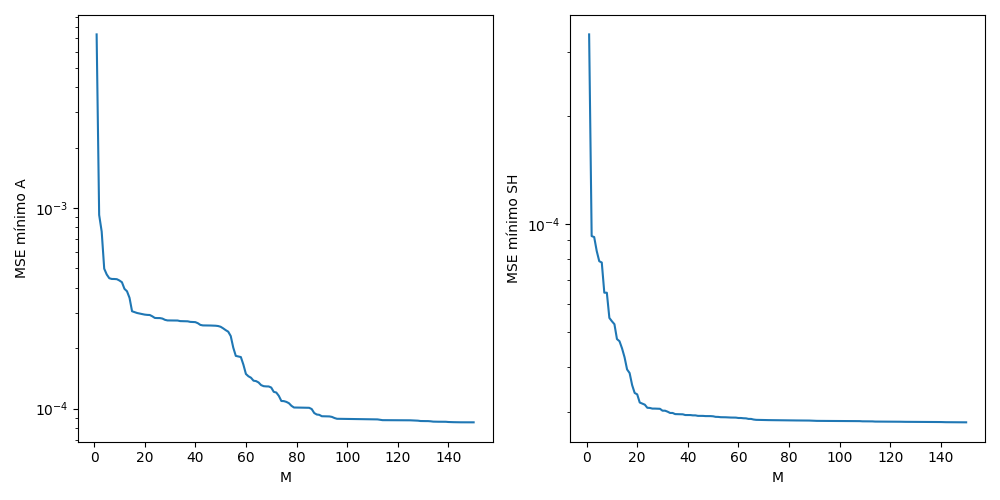

In [112]:
Ms = np.linspace(1, 150, 150, dtype=int)
wo_a = np.zeros((len(Ms)), dtype=np.ndarray)
wo_sh = np.zeros((len(Ms)), dtype=np.ndarray)
jos_a = np.zeros(len(Ms))
jos_sh = np.zeros(len(Ms))
a_a = np.zeros((len(Ms)), dtype=np.ndarray)
a_sh = np.zeros((len(Ms)), dtype=np.ndarray)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)

for i, M in enumerate(Ms):
    wo, jo, NMSE = hp.get_optimal_params(signal["a"], M)
    jos_a[i] = jo
    a_a[i] = np.insert(-wo, 0, 1) 
    wo_a[i] = wo

    wo, jo, NMSE = hp.get_optimal_params(signal["sh"], M)
    wo_sh[i] = wo
    jos_sh[i] = jo
    a_sh[i] = np.insert(-wo, 0, 1) 

axs[0].set_xlabel('M')
axs[0].set_ylabel('MSE mínimo A')
axs[0].plot(Ms, jos_a)
axs[0].set_yscale('log')

axs[1].set_xlabel('M')
axs[1].set_ylabel('MSE mínimo SH')
axs[1].plot(Ms, jos_sh)
axs[1].set_yscale('log')


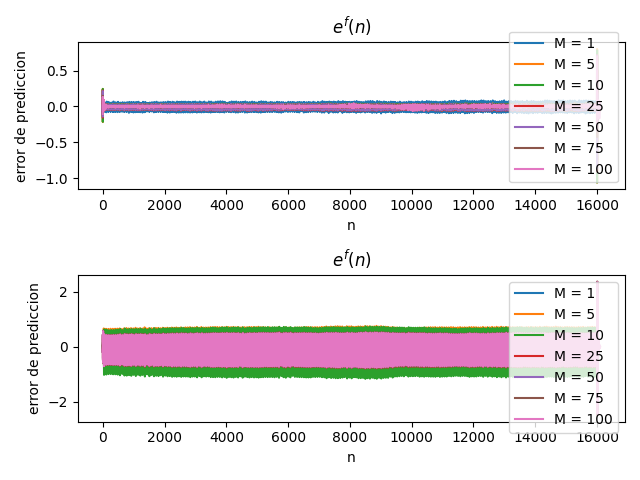

In [113]:
plt.figure(tight_layout=True)
plt.subplot(211)
for i in [1, 5, 10, 25, 50, 75, 100]:
    N = len(a_a[i])
    e_foa = np.convolve(a_a[i], signal["a"])
    plt.plot(e_foa, label=f'M = {i}')

plt.title("$e^f(n)$")
plt.xlabel("n")
plt.ylabel("error de prediccion")
plt.legend()

plt.subplot(212)
for i in [1, 5, 10, 25, 50, 75, 100]:
    N = len(a_sh[i])
    e_foa = np.convolve(a_sh[i], signal["a"])
    plt.plot(e_foa, label=f'M = {i}')

plt.title("$e^f(n)$")
plt.xlabel("n")
plt.ylabel("error de prediccion")
plt.legend()


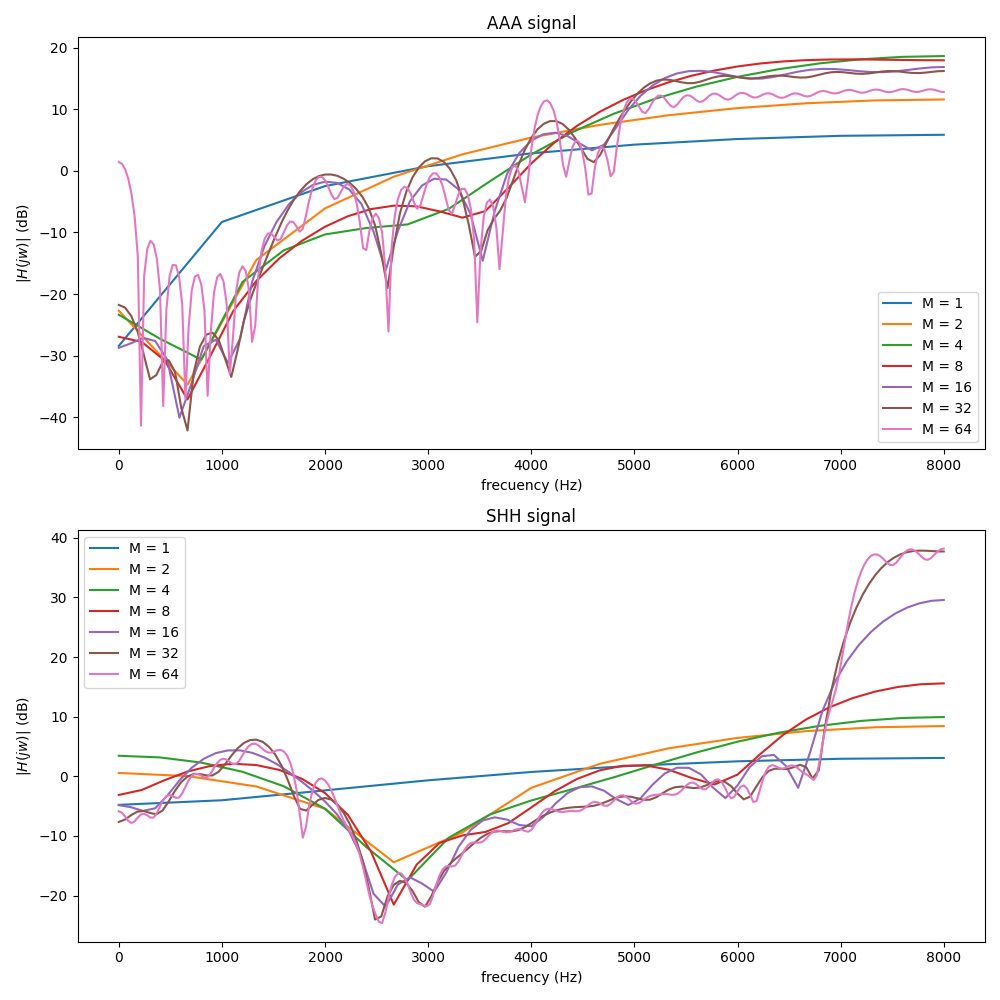

In [114]:
plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(211)
for i in np.logspace(0, 6, 7, endpoint=True, base=2, dtype=int):
    N = len(a_a[i-1])
    freq = rfftfreq(N*8, 1/fs)
    Hejw = rfft(a_a[i-1], N*8)
    A = 20*np.log10((np.abs(Hejw)+1e-18))
    plt.plot(freq, A, label=f'M = {i}')

plt.title("AAA signal")
plt.xlabel("frecuency (Hz)")
plt.ylabel("$|H(jw)|$ (dB)")
plt.legend()

plt.subplot(212)
for i in np.logspace(0, 6, 7, endpoint=True, base=2, dtype=int):
    N = len(a_sh[i-1])
    freq = rfftfreq(N*8, 1/fs)
    Hejw = rfft(a_sh[i-1], N*8)
    A = 20*np.log10((np.abs(Hejw)+1e-18))
    plt.plot(freq, A, label=f'M = {i}')

plt.title("SHH signal")
plt.xlabel("frecuency (Hz)")
plt.ylabel("$|H(jw)|$ (dB)")
plt.legend()

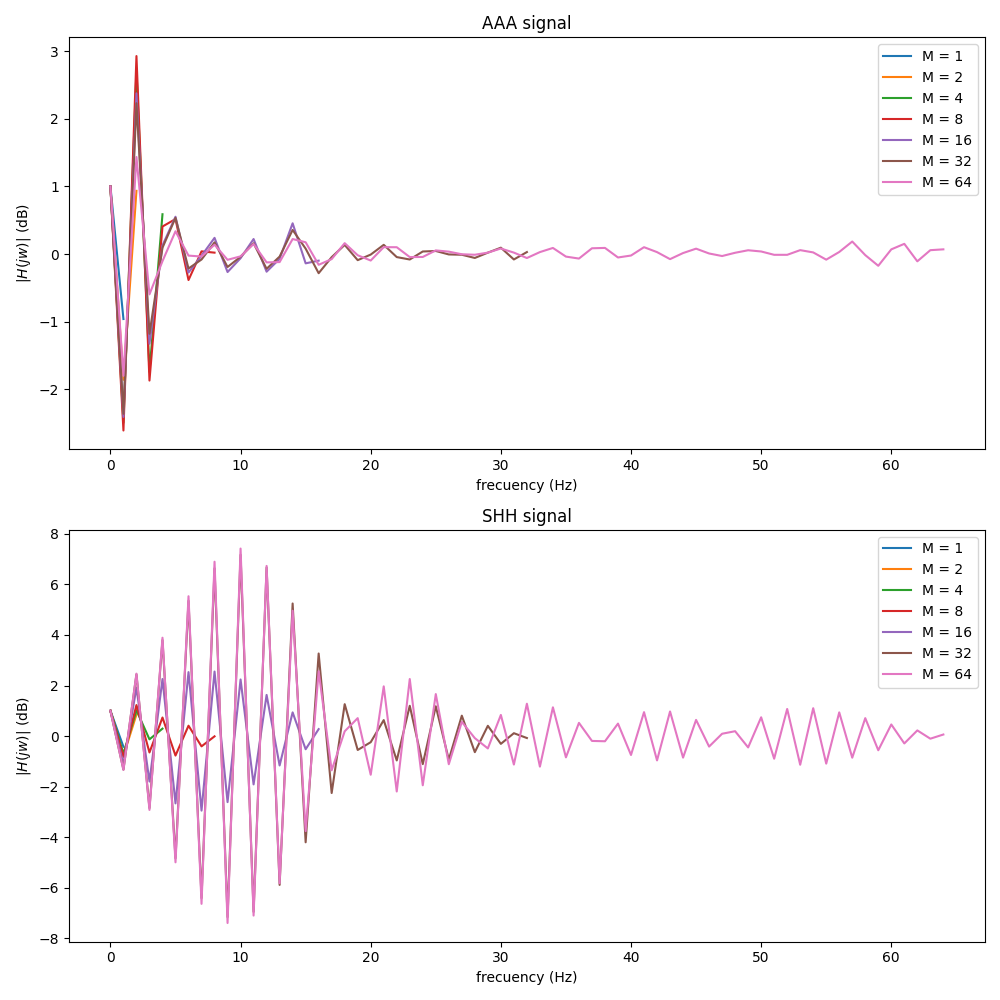

In [115]:
plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(211)
for i in np.logspace(0, 6, 7, endpoint=True, base=2, dtype=int):
    N = len(a_a[i-1])
    plt.plot(a_a[i-1], label=f'M = {i}')

plt.title("AAA signal")
plt.xlabel("frecuency (Hz)")
plt.ylabel("$|H(jw)|$ (dB)")
plt.legend()

plt.subplot(212)
for i in np.logspace(0, 6, 7, endpoint=True, base=2, dtype=int):
    N = len(a_sh[i-1])
    plt.plot(a_sh[i-1], label=f'M = {i}')

plt.title("SHH signal")
plt.xlabel("frecuency (Hz)")
plt.ylabel("$|H(jw)|$ (dB)")
plt.legend()

In [134]:
err_sint = np.random.normal(0, 0.01, fs*2)
out = sp.lfilter([1], a_a[100], err_sint)
display(out.shape)
Audio(data=out, rate=fs)

(32000,)

In [133]:
err_sint = np.random.normal(0, 0.01, fs*2)
out = sp.lfilter([1], a_sh[40], err_sint)
display(out.shape)
Audio(data=out, rate=fs)

(32000,)

In [177]:
fs, frase = io.wavfile.read("recFrase1.wav")
L = 800
overlap = 400
hann_window = sp.get_window('hann', L)
splitted_frase = [frase[i*overlap : i*overlap + L]*hann_window for i in range(0, len(frase)//overlap-1)]
print(np.array(splitted_frase).shape)


(351, 800)


/tmp/ipykernel_18958/3258275125.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, frase = io.wavfile.read("recFrase1.wav")
